bool
(65, 65)


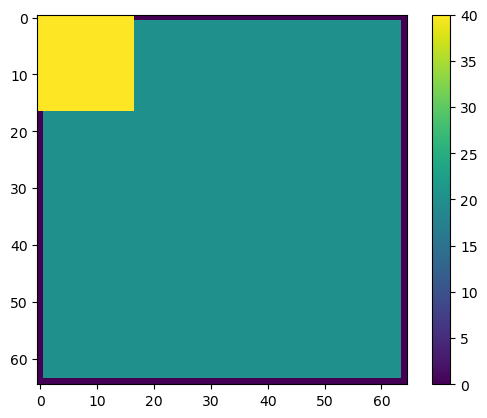

In [17]:
"""
TODO:
- make masks for the heater and boundary

- re-create restrict, prolong, relax, calculate_residual

"""

import numpy as np
import matplotlib.pyplot as plt
# correction[heater_mask] = 0.0
def generate_heater_mask(grid):
    """
    This function makes a boolean array, with 1's inside the heater region and 0's everywhere else.
    It uses coordinates and rounding to make sure our region is more physically accurate.
    """
    heater_mask = np.zeros_like(grid, dtype=bool) #grid is type float64, so we need to change that
    N = grid.shape[0]

    for i in range(0, N):
        for j in range(0, N):
            x = i / (N - 1)
            y = j / (N - 1)
            heater_mask[i, j] = (x <= 0.25) and (y <= 0.25)
    # not sure why the above doesn't make heater_mask boolean, but we'll just recast it to fix it
    
    return heater_mask


def apply_bc(grid):
    """
    This function  sets all the boundaries to zero.
    Important to note: Since this sets ALL boundaries to zero, including the heater region,
    the heater mask should always be used AFTER this is called, not before.
    """

    grid[0, :] = 0.0
    grid[-1, :] = 0.0
    grid[:, 0] = 0.0
    grid[:, -1] = 0.0

    
grid = np.full((65, 65), 20)

heater_mask = generate_heater_mask(grid)
print(heater_mask.dtype)
print(grid.shape)
apply_bc(grid)
grid[heater_mask] = 40.0
heater_region = []

plt.imshow(grid)
plt.colorbar()
plt.show()
    

In [49]:
def jacobi_step(T, rhs, heater_mask):
    """
    Perform one Jacobi relaxation step, skipping heater cells.
    
    Parameters:
        T (np.ndarray): Current temperature grid (shape (N+1, N+1))
        heater_mask (np.ndarray): Boolean array marking fixed heater cells
    Returns:
        T_new (np.ndarray): Updated grid
    """
    
    
    T_new = T.copy()
    N = T_new.shape[0]
    h = 1 / (N-1)
    for i in range(1, N-1):
        for j in range(1, N-1):
            if not heater_mask[i,j]:
                T_new[i,j] = 0.25*(
                    T[i-1, j] +
                    T[i+1, j] +
                    T[i, j-1] +
                    T[i, j+1] -
                    (h**2)*rhs[i,j]
                )

    return T_new


def relax(T, rhs, heater_mask, steps=100):
    
    T_new = T.copy()

    for i in range(steps):
        T_new = jacobi_step(T_new, rhs = rhs, heater_mask = heater_mask)

    return T_new


def restrict(fine):
    """
    Restricts a fine grid to a coarser grid using a 9-point full-weighting stencil.
    
    Parameters:
        fine (np.ndarray): 2D fine grid of shape (N+1, N+1), where N is even
    
    Returns:
        coarse (np.ndarray): 2D coarse grid of shape (N//2 + 1, N//2 + 1)
    """
    N = fine.shape[0] - 1
    # assert N % 2 == 0, f"Grid size must be 2^k for some integer k (even number of intervals). Size is {N} by {N}"

    M = N // 2  # Number of intervals on the coarse grid
    coarse = np.zeros((M + 1, M + 1))

    # Apply the 9-point full-weighting stencil
    for i in range(1, M):
        for j in range(1, M):
            fi, fj = 2 * i, 2 * j  # map coarse index to fine grid index

            # coarse[i, j] = (
            #     1/16 * fine[fi - 1, fj - 1] + 1/8 * fine[fi - 1, fj] + 1/16 * fine[fi - 1, fj + 1] +
            #     1/8  * fine[fi,     fj - 1] + 1/4 * fine[fi,     fj] + 1/8  * fine[fi,     fj + 1] +
            #     1/16 * fine[fi + 1, fj - 1] + 1/8 * fine[fi + 1, fj] + 1/16 * fine[fi + 1, fj + 1]
            # )

            coarse[i, j] = fine[fi, fj]

    return coarse

    
def compute_residual(grid, rhs, L=1.0, heater_mask=None):
    """
    Computes the residual of the Laplace equation on a square domain with Dirichlet boundary and heater mask.
    
    Parameters:
    grid (np.ndarray): Current solution array u (shape: (N+1, N+1))
    rhs (np.ndarray): Right-hand side f (same shape)
    L (float): Physical domain size (default 1.0)
    heater_mask (np.ndarray): Boolean mask of fixed-temperature heater zones
    
    Returns:
    residual (np.ndarray): Residual array of same shape
    """
    N = grid.shape[0] - 1
    h = L / N
    residual = np.zeros_like(grid)
    MAX_ERROR = 1000


    # Skip mask: boundaries and heater
    skip_mask = np.zeros_like(grid, dtype=bool)
    skip_mask[0, :] = True
    skip_mask[-1, :] = True
    skip_mask[:, 0] = True
    skip_mask[:, -1] = True

    # if (grid.shape[0] == 17):
    #     print("heater mask at [1,4]:", heater_mask[1,4])    
    
    if heater_mask is not None:
        skip_mask |= heater_mask # this is a logical OR
    
    for i in range(1, N):
        for j in range(1, N):
            if not skip_mask[i, j]:
                laplace = (grid[i+1, j] + grid[i-1, j] + grid[i, j+1] + grid[i, j-1] - 4 * grid[i, j]) / h**2
                residual[i, j] = rhs[i, j] - laplace

                # if residual[i, j] > MAX_ERROR:
                #     print(f"high error at level {residual.shape}, location {i},{j}")
    # if(grid.shape[0] == 17):
    #     plt.imshow(generate_heater_mask(grid))
    #     plt.title("heater mask for (17, 17) grid")
    #     plt.show()
    
    return residual


def prolong(coarse):
    """
    Prolongs a coarse grid to a finer grid using bilinear interpolation (standard 2D multigrid).
    
    Parameters:
        coarse (np.ndarray): 2D array of shape (N_c + 1, N_c + 1)
    
    Returns:
        fine (np.ndarray): 2D array of shape (2*N_c + 1, 2*N_c + 1)
    """
    N_c = coarse.shape[0] - 1
    N_f = 2 * N_c
    fine = np.zeros((N_f + 1, N_f + 1))

    for i in range(N_c):
        for j in range(N_c):
            ci, cj = 2 * i, 2 * j

            # Coarse point → fine center
            fine[ci, cj] = coarse[i, j]

            # Horizontal midpoint
            fine[ci + 2, cj] = coarse[i + 1, j]
            fine[ci + 1, cj] = 0.5 * (coarse[i, j] + coarse[i + 1, j])

            # Vertical midpoint
            fine[ci, cj + 2] = coarse[i, j + 1]
            fine[ci, cj + 1] = 0.5 * (coarse[i, j] + coarse[i, j + 1])

            # Diagonal midpoint
            fine[ci + 1, cj + 1] = 0.25 * (
                coarse[i, j] + coarse[i+1, j] + coarse[i, j+1] + coarse[i+1, j+1]
            )

            # Remaining corner
            fine[ci + 2, cj + 2] = coarse[i + 1, j + 1]
            fine[ci + 1, cj + 2] = 0.5 * (coarse[i, j + 1] + coarse[i + 1, j + 1])
            fine[ci + 2, cj + 1] = 0.5 * (coarse[i + 1, j] + coarse[i + 1, j + 1])

    return fine


In [53]:
def v_cycle(grid, levels, rhs):
    current_lvl = levels
    heater_mask = generate_heater_mask(grid)
    # check if we're on the lowest level
    # print(grid.shape)
    if levels == 1:
        grid = relax(grid, rhs = rhs, heater_mask = heater_mask)
        
        return grid

    # pre-smoothing
    for i in range(5):
        grid = relax(grid, rhs = rhs, heater_mask = heater_mask)

    # calculate the residual of the grid
    residual = compute_residual(grid, rhs = rhs, heater_mask=heater_mask)

    plt.imshow(residual)
    plt.colorbar()
    plt.title(f"Residue at grid size {grid.shape}")
    plt.show()
    print(f"Residua L2 error: {np.linalg.norm(residual)}")

    # restrict the residual of the grid
    coarse_residual = restrict(residual)

    # solve on the coarser grid to get the correction
    coarse_grid = np.zeros_like(coarse_residual) # our initial guess for the coarser grid is all zeros
    correction = v_cycle(grid = coarse_grid, levels = current_lvl - 1, rhs = coarse_residual)

    # prolong the correction back up the V cycle
    correction = prolong(correction) # prolong = interpolate

    
    # zero out the correction in the heater region
    correction[heater_mask] = 0.0

    # add correction to the grid
    grid += correction

    # post-smoothing
    for i in range(5):
        grid = relax(grid, rhs = rhs, heater_mask = heater_mask)

    #re-assert regions 
    apply_bc(grid) # boundary conditions
    grid[heater_mask] = 40.0 # heater region

    
    return grid
    

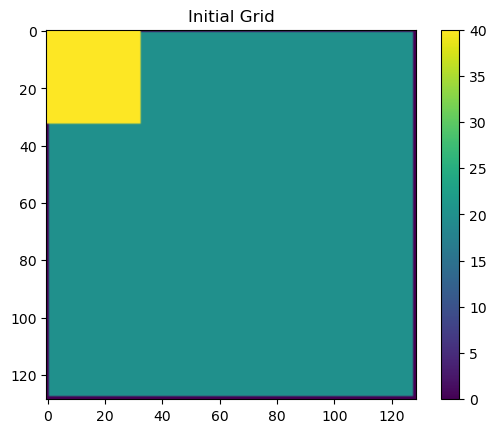

In [54]:
grid = np.full((129, 129), 20.0) # 20 degree room
rhs = np.zeros_like(grid)


heater_mask = generate_heater_mask(grid)
apply_bc(grid)
grid[heater_mask] = 40

plt.imshow(grid)
plt.colorbar()
plt.title("Initial Grid")
plt.show()


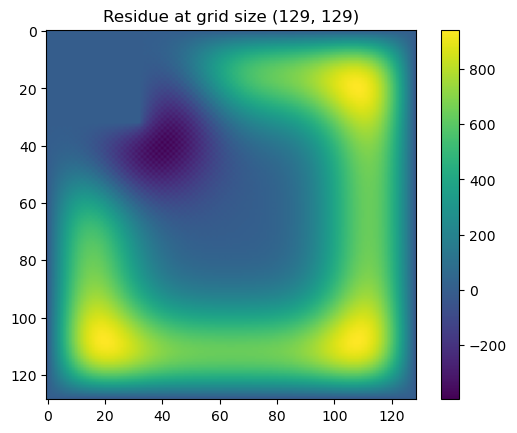

Residua L2 error: 54373.98366731184


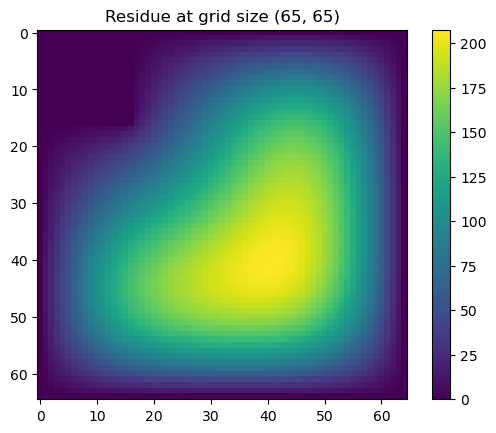

Residua L2 error: 6894.981576302027


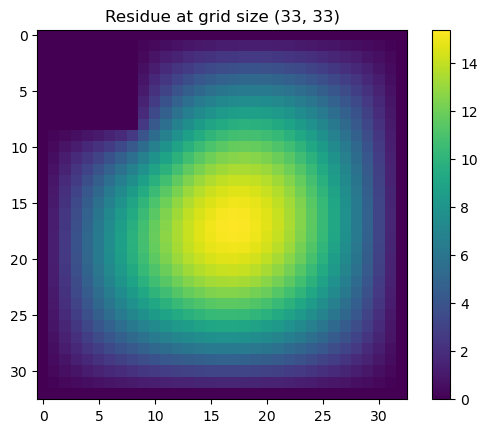

Residua L2 error: 236.26182523035644


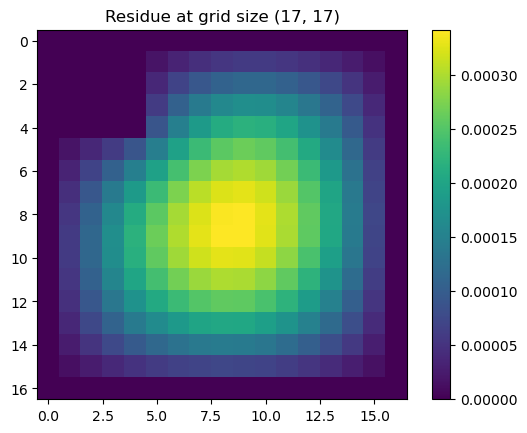

Residua L2 error: 0.002648184141421687


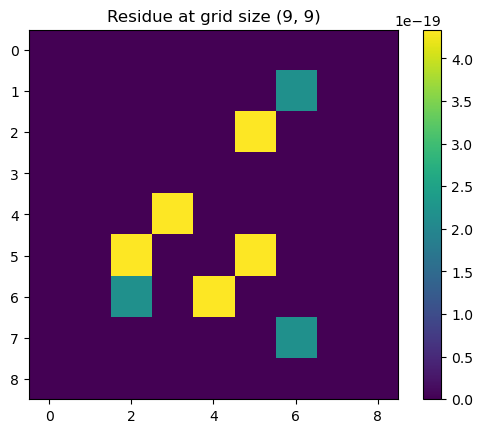

Residua L2 error: 1.0399301912900232e-18


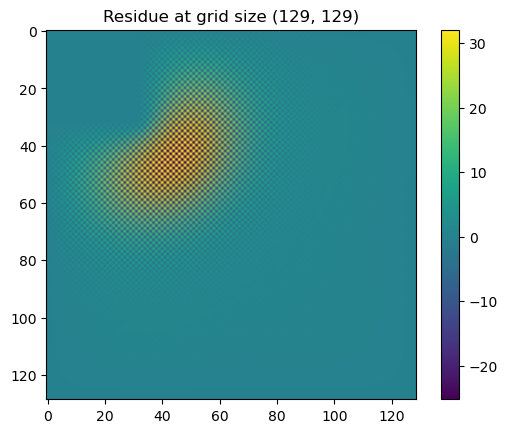

Residua L2 error: 977.7494514600174


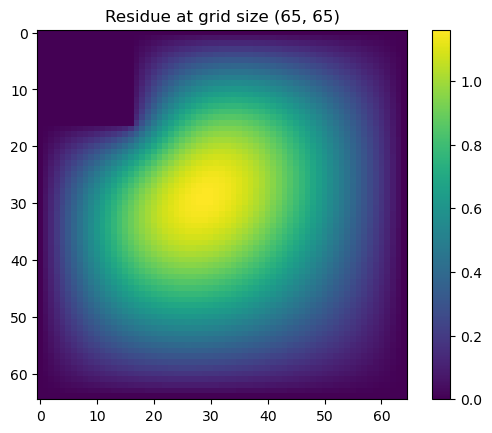

Residua L2 error: 34.64115428811367


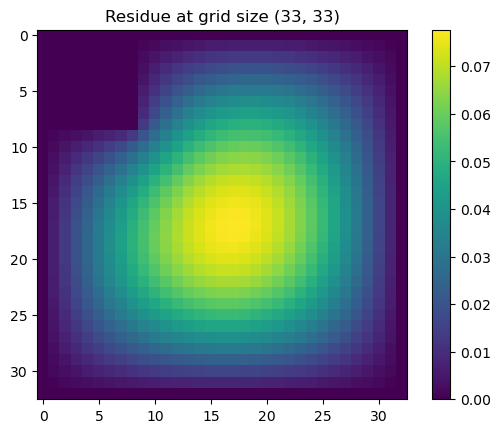

Residua L2 error: 1.1938015046926687


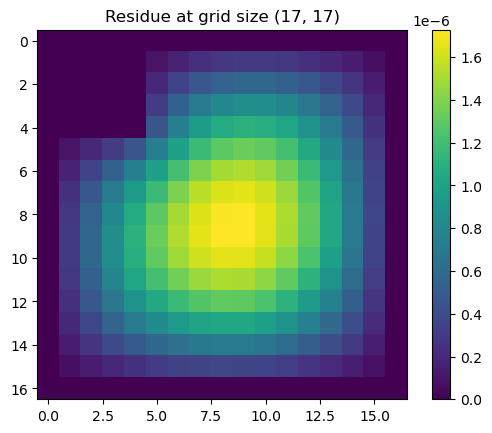

Residua L2 error: 1.338065671247659e-05


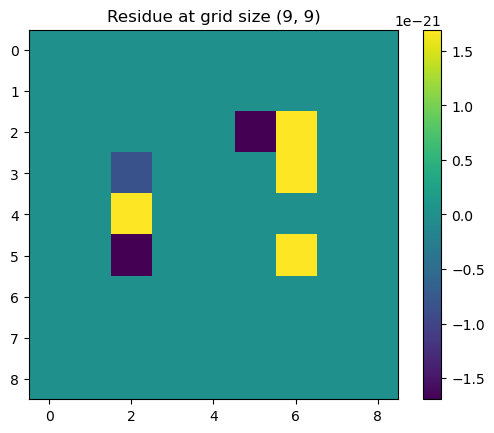

Residua L2 error: 4.235164736271502e-21
V-cycles: 0 
 Error: 717064.158
* * * * * * * * * 


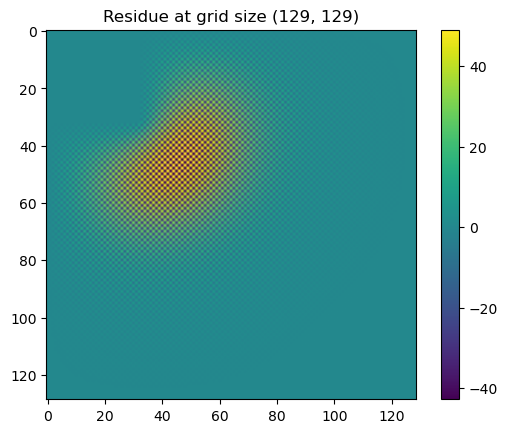

Residua L2 error: 1724.056081659326


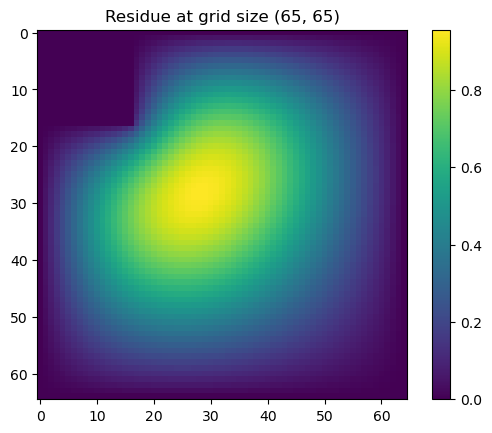

Residua L2 error: 27.413882486216625


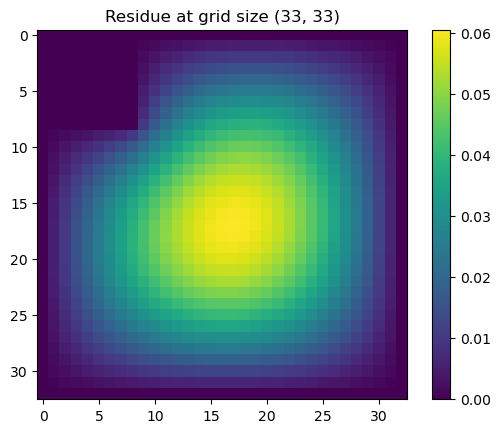

Residua L2 error: 0.9308021844309484


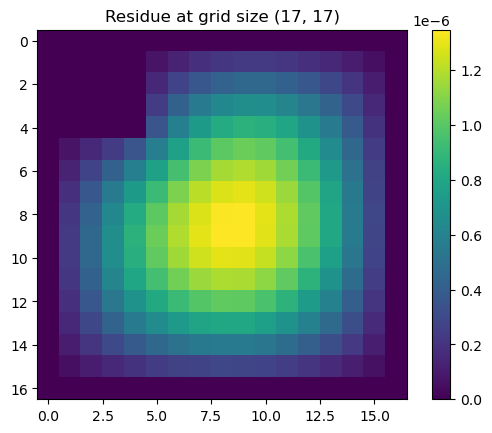

Residua L2 error: 1.0432786059121395e-05


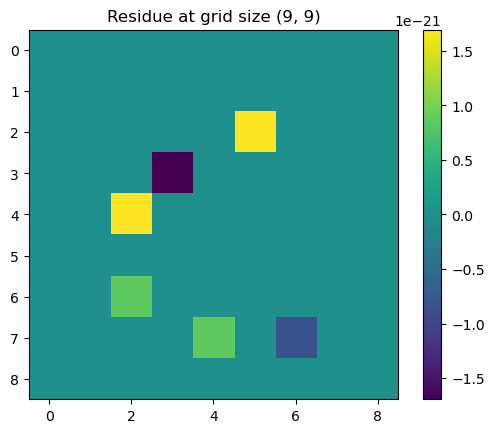

Residua L2 error: 3.2805444984048907e-21
V-cycles: 1 
 Error: 717066.297
* * * * * * * * * 


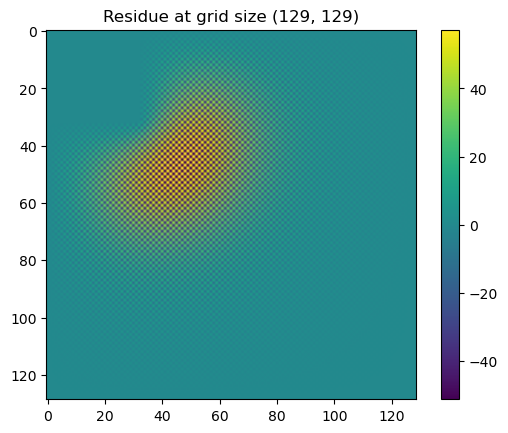

Residua L2 error: 2162.754755712251


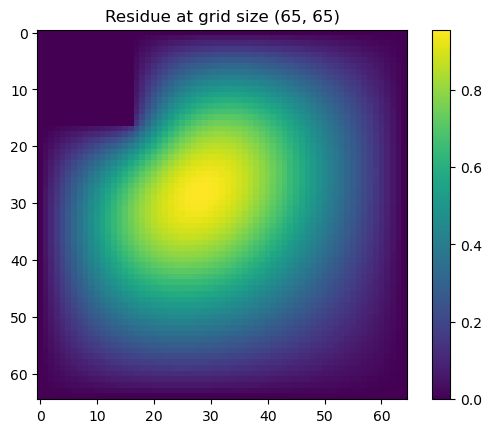

Residua L2 error: 27.403261571101435


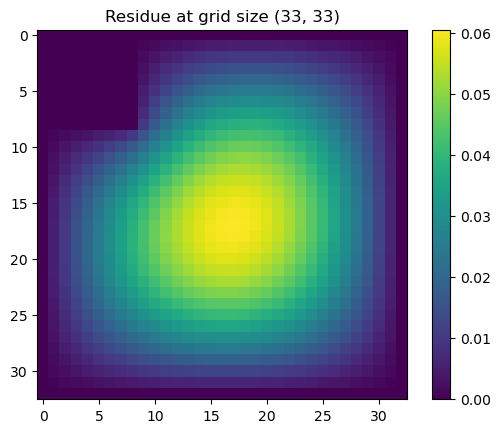

Residua L2 error: 0.9304264236364268


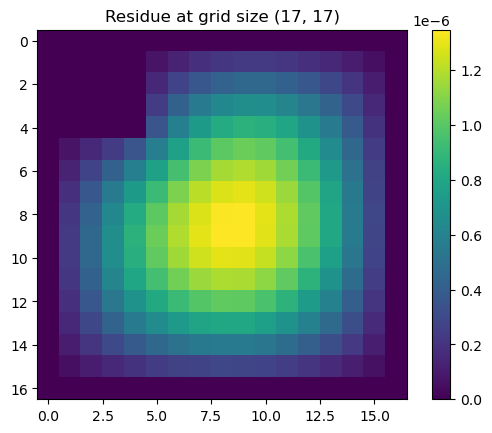

Residua L2 error: 1.0428574329199585e-05


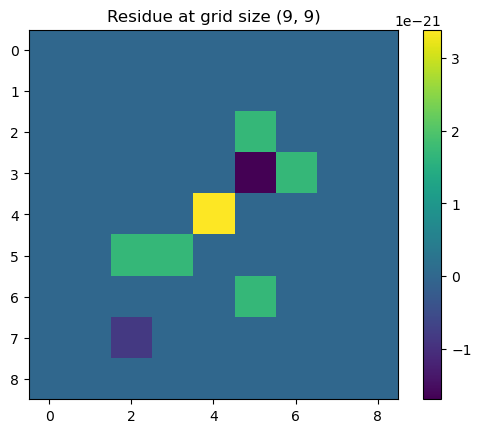

Residua L2 error: 5.42365719446819e-21
V-cycles: 2 
 Error: 717067.742
* * * * * * * * * 


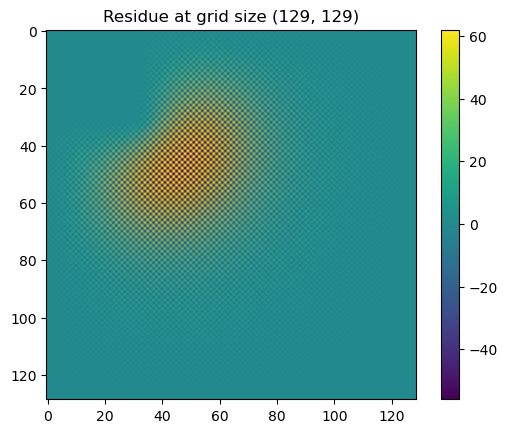

Residua L2 error: 2452.255611660817


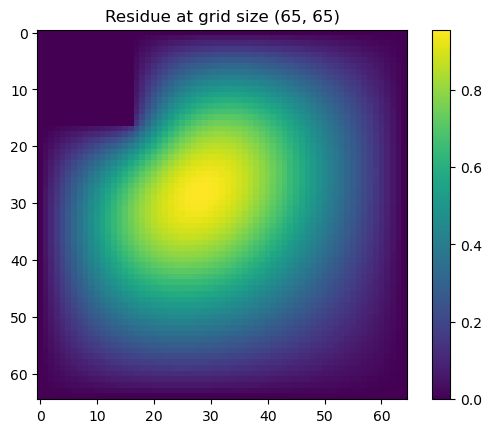

Residua L2 error: 27.403247157297443


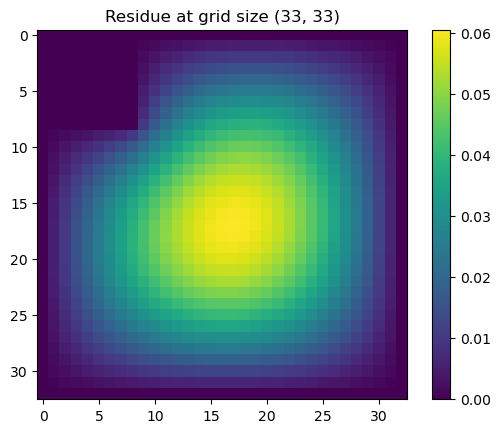

Residua L2 error: 0.9304259488681393


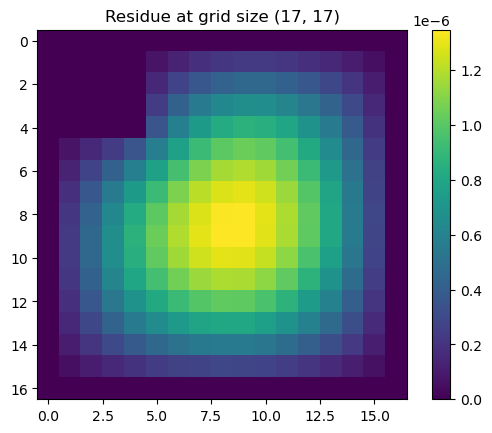

Residua L2 error: 1.0428569008051466e-05


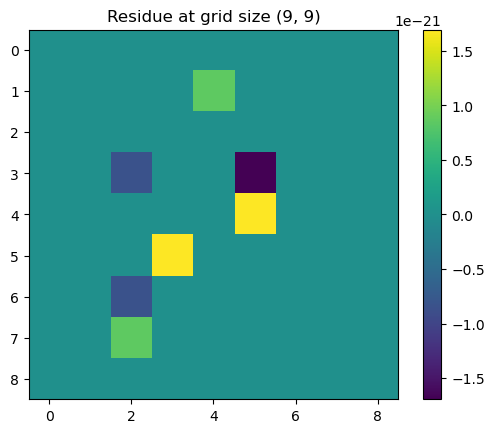

Residua L2 error: 3.3881317890172014e-21
V-cycles: 3 
 Error: 717068.793
* * * * * * * * * 


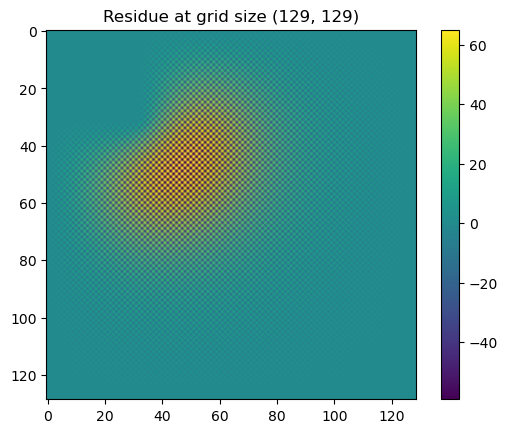

Residua L2 error: 2653.4689064049667


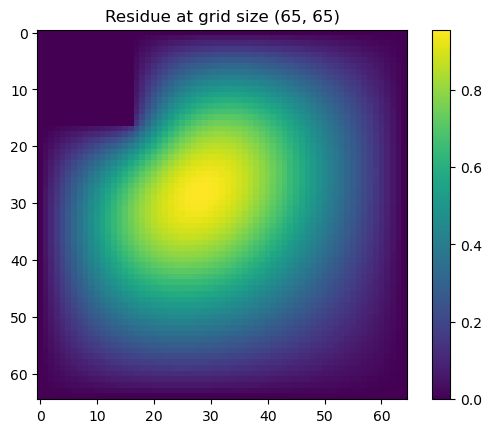

Residua L2 error: 27.40324804319095


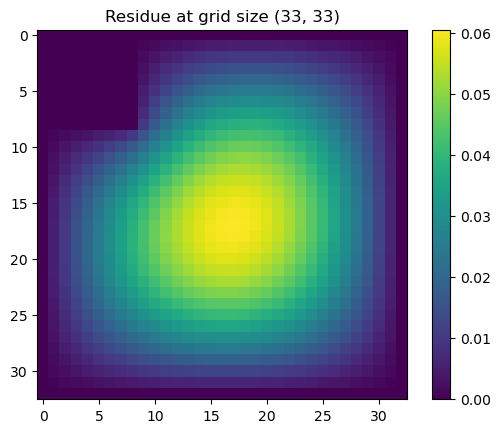

Residua L2 error: 0.9304259970290886


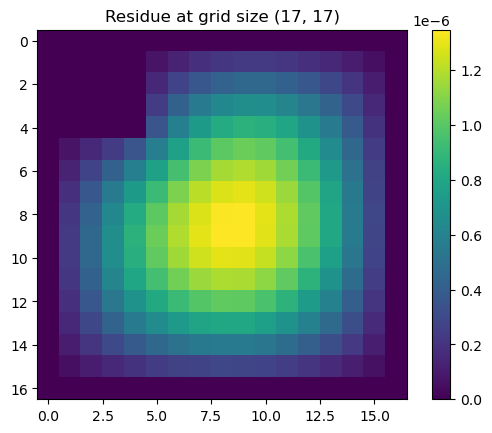

Residua L2 error: 1.0428569547748684e-05


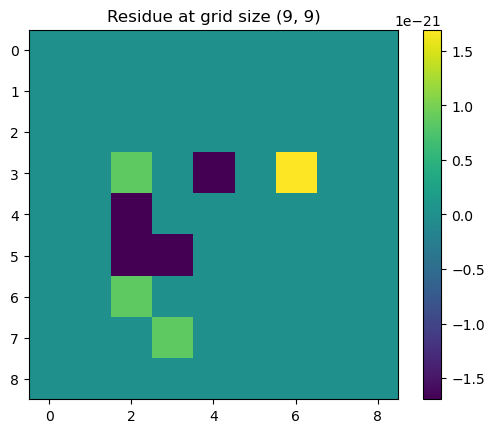

Residua L2 error: 4.062227309726653e-21
V-cycles: 4 
 Error: 717069.567
* * * * * * * * * 


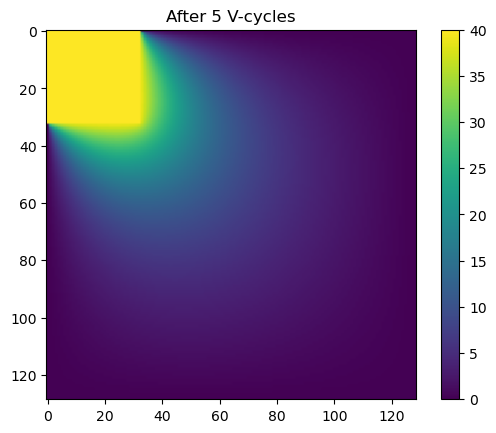

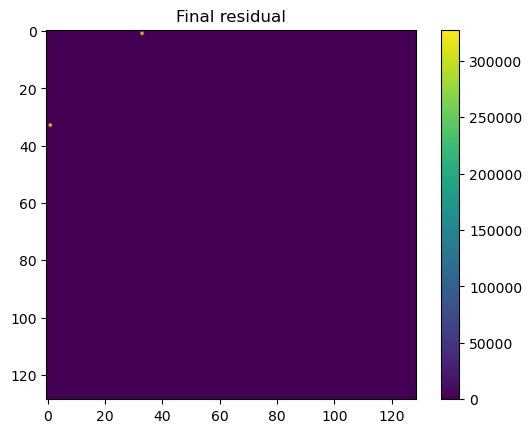

In [55]:
v_cycle_solution = v_cycle(grid, levels = 6, rhs = rhs)

for i in range(5):
    v_cycle_solution = v_cycle(v_cycle_solution, levels = 6, rhs = rhs)
    my_error = np.linalg.norm(compute_residual(v_cycle_solution, rhs))
    print(f"V-cycles: {i} \n Error: {my_error:.3f}")
    print("* * * * * * * * * ")

plt.imshow(v_cycle_solution)
plt.colorbar()
plt.title("After 5 V-cycles")
plt.show()


plt.imshow(compute_residual(v_cycle_solution, rhs=rhs, heater_mask = heater_mask))
plt.colorbar()
plt.title("Final residual")
plt.show()

In [8]:
def full_multigrid(grid, levels, rhs):
    heater_mask = generate_heater_mask(grid)
    
    # check our recursion condition (how many levels are we going up?)
    if levels == 1:
        grid = relax(grid, rhs = rhs, heater_mask = heater_mask)
        return grid
    
    # start with the coarse grid

    # plt.imshow(grid)
    # plt.colorbar()
    # plt.title(f"Grid level {-1*(levels) + 6}, BEFORE relaxing")
    # plt.show()
    
    # relax the coarse grid
    grid = relax(grid, rhs = rhs, heater_mask = heater_mask)

    # plt.imshow(grid)
    # plt.colorbar()
    # plt.title(f"Grid level {-1*(levels) + 6}, AFTER relaxing")
    # plt.show()
        
    # prolong the coarse grid to a finer grid, prolong other grids which are used in operations with it
    fine_grid = prolong(grid)
    heater_mask = generate_heater_mask(fine_grid)
    rhs = prolong(rhs)
    
    fine_grid = relax(fine_grid, rhs = rhs, heater_mask = heater_mask)
    apply_bc(fine_grid)
    fine_grid[heater_mask] = 40.0

    # recursion step 
    solution = full_multigrid(grid = fine_grid, levels = levels - 1, rhs = rhs)

    heater_mask = generate_heater_mask(solution)

    apply_bc(solution)
    solution[heater_mask] = 40.0
    
    return solution
    

In [9]:
grid = np.full((9, 9), 20.0)
heater_mask = generate_heater_mask(grid)

apply_bc(grid)
grid[heater_mask] = 40.0

rhs = np.zeros_like(grid)



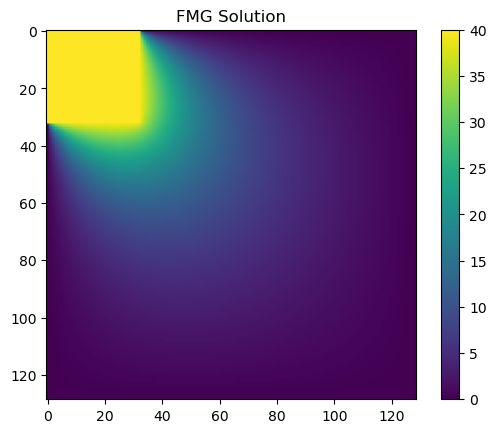

In [10]:
FMG_solution = full_multigrid(grid, levels = 5, rhs = rhs)

plt.imshow(FMG_solution)
plt.colorbar()
plt.title("FMG Solution")
plt.show()